# Info/CS 4300: Language and Information - in-class demo


## Sentiment analysis 
### Discovering polarity lexicons from labeled data

In [32]:
%matplotlib inline

from __future__ import print_function,division
import json
from operator import itemgetter
from collections import defaultdict

import numpy as np
from matplotlib import pyplot as plt
from nltk.tokenize import TreebankWordTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import load_files
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC



In [33]:
## loading movie review data: 
## http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz

data = load_files('txt_sentoken')

## First review and first label:
print(data.data[0])
print(data.target[0])

b"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so called dark thriller , the devil ( gabriel byrne ) has come upon earth , to impregnate a woman ( robin tunney ) which happens every 1000 years , and basically destroy the world , but apparently god has chosen one man , and that one man is jericho cane ( arnold himself ) . \nwith the help of a trusty sidekick ( kevin pollack ) , they will stop at nothing to let the devil take over the world ! \nparts of this are actually so absurd , that they would fit right in with dogma . \nyes , the film is 

In [34]:
## Building the term document matrix using CountVectorizer
vec = CountVectorizer(min_df=50)
X = vec.fit_transform(data.data)
terms = vec.get_feature_names()
len(terms)

2153

In [35]:
## METHOD 1: We estimate the positive_score as P(Positive|W)
def wordscore_pos():
    total_count = X.sum(axis=0)                 # shape (1, n_terms)
    pos_count = X[data.target == 1].sum(axis=0) # shape (1, n_terms)
    
    # make sure they are 1d np.arrays
    total_count = np.asarray(total_count).ravel()
    pos_count = np.asarray(pos_count).ravel()
    
    prob = pos_count * 1.0 / total_count
    return zip(terms,prob)


In [36]:
## most "negative" words
negative_movies=sorted(wordscore_pos(), key=itemgetter(1), reverse=False)[:20]
negative_movies

[('lame', 0.13513513513513514),
 ('wasted', 0.1440677966101695),
 ('poorly', 0.14893617021276595),
 ('waste', 0.15384615384615385),
 ('ridiculous', 0.15714285714285714),
 ('awful', 0.1590909090909091),
 ('worst', 0.1590909090909091),
 ('unfunny', 0.17045454545454544),
 ('stupid', 0.17786561264822134),
 ('dull', 0.1791044776119403),
 ('painfully', 0.18333333333333332),
 ('pointless', 0.18478260869565216),
 ('laughable', 0.1891891891891892),
 ('boring', 0.1925925925925926),
 ('terrible', 0.1958041958041958),
 ('embarrassing', 0.2),
 ('bland', 0.20238095238095238),
 ('mess', 0.20754716981132076),
 ('badly', 0.21052631578947367),
 ('anywhere', 0.21818181818181817)]

In [37]:
positive_movies=sorted(wordscore_pos(),key = itemgetter(1),reverse = True)[:20]
positive_movies

[('outstanding', 0.9324324324324325),
 ('wonderfully', 0.8823529411764706),
 ('nomination', 0.8387096774193549),
 ('era', 0.8372093023255814),
 ('fantastic', 0.8181818181818182),
 ('portrayal', 0.8160919540229885),
 ('cameron', 0.8159509202453987),
 ('jackie', 0.8091872791519434),
 ('superb', 0.8064516129032258),
 ('pulp', 0.8037383177570093),
 ('memorable', 0.8027210884353742),
 ('terrific', 0.8),
 ('political', 0.7987012987012987),
 ('allows', 0.7934782608695652),
 ('excellent', 0.7934782608695652),
 ('satisfying', 0.7903225806451613),
 ('wars', 0.7877094972067039),
 ('contrast', 0.7846153846153846),
 ('perfectly', 0.7831325301204819),
 ('portrayed', 0.7777777777777778)]

In [38]:
# METHOD 2: Use class probabilities already calculated by your NB classifier

In [39]:
sentiment_classifier=MultinomialNB()
sentiment_classifier.fit(X,data.target)
predicted_classes_train=sentiment_classifier.predict(X)
print("Accuracy on train: {:.2f}%".format(np.mean(predicted_classes_train == data.target) * 100))

Accuracy on train: 86.40%


In [40]:
# don't forget to check this against the majority baseline:

sum(data.target)/len(data.target)

0.5

In [41]:

positive_lexicon=[]

negative_lexicon=[]

# P(word|positive)
positives_probs=sentiment_classifier.feature_log_prob_[0,:]

# P(word|negative)
negative_probs=sentiment_classifier.feature_log_prob_[1,:]

logodds=positives_probs-negative_probs

#positive
print("\nFeatures that are most indicative of positive sentiment:\n")
for i in np.argsort(logodds)[:20]:
    print(terms[i])
    
print("\n\nFeatures that are most indicative of negative sentiment\n")
#negative
for i in np.argsort(-logodds)[:20]:
    print(terms[i])

# put the top/bottom words in the positive/negative lexicons
for i in np.argsort(logodds)[:500]:
    positive_lexicon.append(terms[i])
    
#negative
for i in np.argsort(-logodds)[:500]:
    negative_lexicon.append(terms[i])

positive_lexicon=set(positive_lexicon)
negative_lexicon=set(negative_lexicon)


Features that are most indicative of positive sentiment:

outstanding
wonderfully
era
nomination
cameron
fantastic
portrayal
jackie
superb
memorable
pulp
terrific
political
excellent
allows
wars
satisfying
perfectly
contrast
subtle


Features that are most indicative of negative sentiment

lame
wasted
poorly
waste
worst
ridiculous
awful
unfunny
stupid
dull
pointless
painfully
boring
laughable
terrible
bland
embarrassing
mess
badly
anywhere


Now we can try to apply what we learned to a data without labels

In [42]:
## Loading the Kardashian data
with open("kardashian-transcripts.json", "rb") as f:
    transcripts = json.load(f)

In [43]:
msgs = [m['text'].lower() for transcript in transcripts
        for m in transcript if m['speaker'] == 'KIM']

In [44]:
## using the same transformation to get a term-document matrix (where terms match the ones in the movie-review data)
X2=vec.transform(msgs)
labels=sentiment_classifier.predict(X2)

In [45]:
#Looking at the classes assigned by the classifier:
z = zip(labels,msgs)
list(z)[:20]

[(0, 'you just need a duster.'),
 (0, 'when did you start to get gray hair?'),
 (0, 'oh, please.'),
 (0, 'oh, my god.'),
 (0, 'it is like $4,000.'),
 (0, "that's crazy."),
 (0, "that's way too much money, mom."),
 (0, "you have so many dresses, and it's just a plain black dress."),
 (0, "it's nothing special."),
 (0, 'capitol one, wells fargo...'),
 (0, "so what's, like, your plan?"),
 (0, 'like, where are you gonna stay?'),
 (0, "i'm just afraid if you go to new york, you'll come back hurt."),
 (1,
  "as much as i don't agree with rob going to new york, he's my little brother."),
 (1, "i'm gonna support him no matter what."),
 (1, "so i call rob to see what's going on with adrienne."),
 (1, "rob, you're crazy."),
 (1,
  "i know he feels that she's the one, and i get it, but rob is taking it to a whole 'nother level."),
 (0, 'i think that at some point, you just need to stop calling her.'),
 (0, 'and i think this is now, like, the turning point.')]

(array([4911.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         954.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

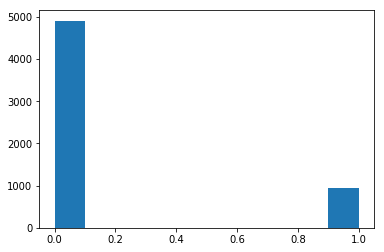

In [46]:
# label distribution (everything has an assigned class, even though not everything might be subjective)
plt.hist(labels.tolist())

(array([ 123.,  391.,  834., 1564., 1626., 1004.,  228.,   78.,   13.,
           4.]),
 array([1.92734069e-04, 9.88536484e-02, 1.97514563e-01, 2.96175477e-01,
        3.94836391e-01, 4.93497306e-01, 5.92158220e-01, 6.90819134e-01,
        7.89480048e-01, 8.88140963e-01, 9.86801877e-01]),
 <a list of 10 Patch objects>)

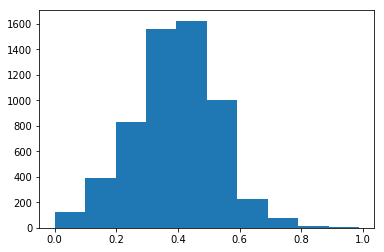

In [47]:
## We can look at the predicted class probabilities
label_prob = sentiment_classifier.predict_proba(X2)
positive_label_probabilities = label_prob[:, 1]
plt.hist(positive_label_probabilities)

In [48]:
## documents that are considered most negative
kard_sentiment=sorted(set(zip(positive_label_probabilities, msgs)),
       key=itemgetter(0),
       reverse=False)

for sent_score, m in kard_sentiment[:20]:
    print (sent_score, m)
    print ("lexicon items:",", ".join(list(set(m.split()).intersection(negative_lexicon))))
    print()

0.00019273406884585592 i know that you guys sometimes don't understand what goes on, and i'm sorry if, you know, at school, maybe your friends have said things to you or... come to you with things that maybe you don't know the whole truth about, but you have three big sisters that you can always come to, and when you get to that point and you do like boys, i want you to be able to call me and tell me whatever you want to.
lexicon items: sorry, maybe, big, do, whole, guys, have, point, whatever, get

0.0015970813143444077 i've had time to reflect on what my family's trying to say to me, and it probably wouldn't be such a bad idea if i put myself on a budget i just don't like lying to you guys, and i'm really sorry.
lexicon items: trying, budget, bad, idea, myself, if, just

0.0018022656570855005 this was supposed to be me!" like, i think, you know, like, what if i have a nervous breakdown when they're like, "does anyone object?" what if i'm, like, "this was supposed to be me!" like in a

In [49]:
## documents that are considered most positive
kard_sentiment=sorted(set(zip(positive_label_probabilities, msgs)),
       key=itemgetter(0),
       reverse=False)

for sent_score, m in kard_sentiment[-20:]:
    print (sent_score, m)
    print ("lexicon items:",", ".join(list(set(m.split()).intersection(positive_lexicon))))
    print()

0.7719650891899279 everything from career to family is going perfect.
lexicon items: family

0.7789525214239469 to restore hair's natural defense against frizz.
lexicon items: against, natural

0.7810829263423256 and a strong immune system.
lexicon items: strong

0.7820114680538289 rob asked adrienne to be his date for the wedding and she said that, you know, he can tag along with her and her friends.
lexicon items: date, rob

0.7833492617671066 i'm bringing my best friend brittny gastineau with me for support.
lexicon items: bringing, best

0.7894137428759795 this is gonna be such an amazing life experience for her.
lexicon items: life, experience, amazing

0.7928196558948932 i'm in the best mood, everyone!
lexicon items: best

0.7933490786402522 thanks for understanding.
lexicon items: thanks

0.7934013715140062 fantastic. phenomenal.
lexicon items: 

0.7977885608563229 when it really comes down to it, the most important thing in life is family.
lexicon items: life, important, most



We see that the polarity lexicon does not generalize well from one dataset to another. What can we do?